In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, coherence
from pulse_pair_doppler import pulse_pair_doppler

In [2]:
model = pulse_pair_doppler(
    t_pulse=1.15e-4,                   # s
    t_receive=100e-4,                # s 
    t_interpulse=0*1e-4,              # s
    # n_reflectors=4,            # -    TODO why does this number increase error?
    temporal_decorr=0.8,
    n_pulses=2,                     # -
    n_bursts=35,                    # -
    bandwidth=1e6,                  # hz
    baseband=0,                     # hz   TODO why does this number increase error?
    oversample_retriev=1,           # -    TODO why does this number increase error?
    range_cell_avg_factor=3,        # -
    range_cell_size_frac_pulse=1,   # -
    seed=12,                         # -
)

model.chirp(centre_around_baseband=True)
model.pulse_pairs()
model.simulate_reflection()

pulse_pair_doppler(t_pulse=0.000115, t_receive=0.01, t_interpulse=0.0, n_pulses=2, n_bursts=35, bandwidth=1000000.0, baseband=0, seed=12, temporal_decorr=0.8, n_reflectors=None, oversample_retriev=1, range_cell_avg_factor=3, range_cell_size_frac_pulse=1)

In [3]:
def coherence_calc(signal1, signal2):

    # Yields similar performance as the mean output from scipy.signal.coherence using a 'hann' window

    # Compute the cross-power spectral density (CSD)
    csd = np.mean(signal1 * np.conj(signal2))

    # Compute the power spectral density (PSD) for each signal
    psd_signal1 = np.mean(np.abs(signal1)**2)
    psd_signal2 = np.mean(np.abs(signal2)**2)

    # Calculate the coherence using the CSD and PSD values
    coherence = np.abs(csd)**2 / (psd_signal1 * psd_signal2)

    return coherence

In [4]:
shifts = np.linspace(0, np.pi, 1000)
corr = np.zeros_like(shifts)

for i, shift in enumerate(shifts):
    sig1 = model.simulate_reflection(seed=12, v_avg=12, phi_avg=23).surface
    l2 = len(sig1)
    sig2 = sig1* np.exp(1j*np.random.uniform(low=-shift, high=shift, size = l2))

    corr[i] = coherence_calc(sig1, sig2)

def least_squares(A, y):
    x_hat = np.linalg.inv(A.T @ A) @ A.T @ y
    return x_hat

N = len(corr)
A = np.ones((N, 3))
A[:, 1] = np.cos(shifts)
A[:, 2] = np.cos(shifts)**2
y = corr

x_hat = least_squares(A, y)
x_hat


array([0.40090063, 0.50422944, 0.09862582])

In [5]:
a, b, c = 0.40403017, 0.50515681, 0.09433892
coherence_target = 0.5
phase_shift_domain = np.arccos((-b + np.sqrt(b**2 - 4*c*(a-coherence_target))) / (2*c))
phase_shift_domain

1.3860678793198897

In [9]:
sample_offset = model.pulse_samples + model.interpulse_samples
sig1 = model.subreflections[0][:-sample_offset] #s1
sig2 = model.subreflections[1][sample_offset:] #s2

coherence_calc(sig1, sig2), np.mean(coherence(sig1, sig2, window='hann'), axis = 1)[1]

(0.8075831362119679, 0.8067850614923396)

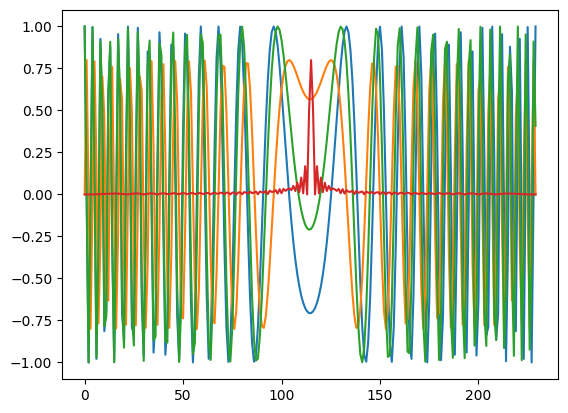

In [6]:
f_dop = model.bandwidth/100
phase_shift = (f_dop) * model.t_pulse_vector

aa = model.pulse
bb = 0.8*model.pulse * np.exp(1j*2*np.pi*0.25)
cc = aa * np.exp(1j * phase_shift) # frequency change

aap = np.arctan2(aa.imag, aa.real)
bbp = np.arctan2(bb.imag, bb.real)

plt.plot(aa)
plt.plot(bb)
plt.plot(cc)
plt.plot(abs(correlate(aa, bb, mode = 'same'))/len(aa))